In [1]:
# Few import statements
import os
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import TimeDistributedDense
from keras.layers.recurrent import LSTM
from IPython.display import Audio
from pipes import quote

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


In [2]:
def read_wav_as_np(file):
    # wav.read returns the sampling rate per second  (as an int) and the data (as a numpy array)
    data = wav.read(file)
    # Normalize 16-bit input to [-1, 1] range
    np_arr = data[1].astype('float32') / 32767.0
    #np_arr = np.array(np_arr)
    return np_arr, data[0]

In [3]:
def write_np_as_wav(X, sample_rate, file):
    # Converting the tensor back to it's original form
    Xnew = X * 32767.0
    Xnew = Xnew.astype('int16')
    # wav.write constructs the .wav file using the specified sample_rate and tensor
    wav.write(file, sample_rate, Xnew)
    return

In [4]:
def convert_sample_blocks_to_np_audio(blocks):
    # Flattens the blocks into a single list
    song_np = np.concatenate(blocks)
    return song_np

In [5]:
def convert_np_audio_to_sample_blocks(song_np, block_size):

    # Block lists initialised
    block_lists = []

    # total_samples holds the size of the numpy array
    total_samples = song_np.shape[0]
    # print('total_samples=',total_samples)

    # num_samples_so_far is used to loop through the numpy array
    num_samples_so_far = 0

    while (num_samples_so_far < total_samples):

        # Stores each block in the "block" variable
        block = song_np[num_samples_so_far:num_samples_so_far + block_size]

        if (block.shape[0] < block_size):
            # this is to add 0's in the last block if it not completely filled
            padding = np.zeros((block_size - block.shape[0],))
            # block_size is 44100 which is fixed throughout whereas block.shape[0] for the last block is <=44100
            block = np.concatenate((block,padding))
        block_lists.append(block)
        num_samples_so_far += block_size
    return block_lists

In [6]:
def time_blocks_to_fft_blocks(blocks_time_domain):
    # FFT blocks initialized
    fft_blocks = []
    for block in blocks_time_domain:
        # Computes the one-dimensional discrete Fourier Transform and returns the complex nD array
        # i.e The truncated or zero-padded input, transformed from time domain to frequency domain.
        fft_block = np.fft.fft(block)
        # Joins a sequence of blocks along frequency axis.
        new_block = np.concatenate((np.real(fft_block), np.imag(fft_block)))
        fft_blocks.append(new_block)
    return fft_blocks

In [7]:
def fft_blocks_to_time_blocks(blocks_ft_domain):
    # Time blocks initialized
    time_blocks = []
    for block in blocks_ft_domain:
        num_elems = block.shape[0] / 2
        # Extracts real part of the amplitude corresponding to the frequency
        real_chunk = block[0:num_elems]
        # Extracts imaginary part of the amplitude corresponding to the frequency
        imag_chunk = block[num_elems:]
        # Represents amplitude as a complex number corresponding to the frequency
        new_block = real_chunk + 1.0j * imag_chunk
        # Computes the one-dimensional discrete inverse Fourier Transform and returns the transformed
        # block from frequency domain to time domain
        time_block = np.fft.ifft(new_block)
        # Joins a sequence of blocks along time axis.
        time_blocks.append(time_block)
    return time_blocks

** Set desired sampling rate and block size. Also assign the path of the music file to _filename_ **

In [8]:
sample_frequency = 44100
block_size = 44100
filename = '/home/subbu/Desktop/Music Preprocessing/Bright Wish.mp3'

In [9]:
files = filename.split('/')
orig_filename = files[-1][0:-4]
if (filename[0] == '/'):
    new_path = '/'
for i in range(len(files) - 1):
    new_path += files[i] + '/'
# We define the file names for the newly created WAV files and the Mono mp3 file
filename_tmp = new_path + orig_filename + 'Mono.mp3'
new_name = new_path + orig_filename + '.wav'

# These lines calls LAME to resample the audio file at the standard analog frequency of 44,100 Hz and then convert it to WAV
sample_freq_str = "{0:.1f}".format(float(sample_frequency) / 1000.0)
cmd = 'lame -a -m m {0} {1}'.format(quote(filename), quote(filename_tmp))
os.system(cmd)
cmd = 'lame --decode {0} {1} --resample {2}'.format(quote(filename_tmp), quote(new_name), sample_freq_str)
os.system(cmd)

0

** Mono version and WAV version of the input MP3 file can now be found in the directory containing the input MP3 file. **


** Visualizing the WAV file **


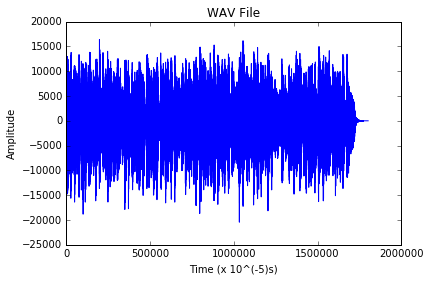

In [10]:
%matplotlib inline
bitrate, data = wav.read(new_name)
plt.plot(data)
plt.title("WAV File")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.show()

In [11]:
# wav_array contains normalized data
wav_array, bitrate = read_wav_as_np(new_name)
# wav_array is converted into blocks with zeroes padded to fill the empty space in last block if any
wav_blocks_zero_padded = convert_np_audio_to_sample_blocks(wav_array, block_size)


** Visualizing Zero Padded WAV File **


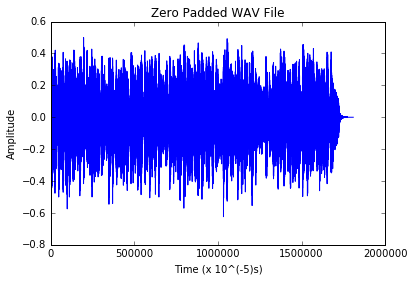

In [12]:
# Flattens the blocks into an array
wav_array_zero_padded = convert_sample_blocks_to_np_audio(wav_blocks_zero_padded)
plt.plot(wav_array_zero_padded)
plt.title("Zero Padded WAV File")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.show()

** Thus, zero padding does not change the waveform. It just makes the matrix computations easier. 
Now shift the zero padded wav blocks to the left by 1 column and use it for computing loss function during the training. Visualizing the shifted file.**

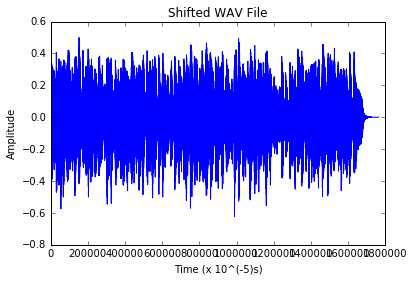

In [13]:
shifted_wav_blocks_zero_padded = wav_blocks_zero_padded[1:]
shifted_wav_array_zero_padded = convert_sample_blocks_to_np_audio(shifted_wav_blocks_zero_padded)
plt.plot(shifted_wav_array_zero_padded)
plt.title("Shifted WAV File")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.show()

In [14]:
# Fast fourier transforming the wav blocks into frequency domain
print('Dimension of wav blocks before fft: ',np.shape(wav_blocks_zero_padded))

X = time_blocks_to_fft_blocks(wav_blocks_zero_padded)
Y = time_blocks_to_fft_blocks(shifted_wav_blocks_zero_padded)

print('Dimension of the training dataset (wav blocks after fft): ',np.shape(X))

Dimension of wav blocks before fft:  (41, 44100)
Dimension of the training dataset (wav blocks after fft):  (41, 88200)


**Visualizing the fast fourier transformed WAV blocks (X: Used for training, Y: Used for computing loss function)**

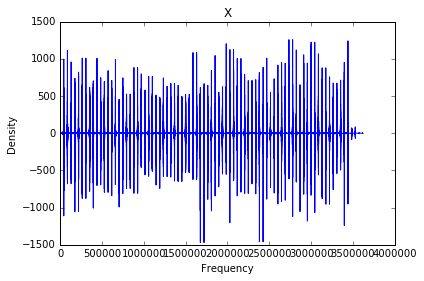

In [15]:
X_flat = np.concatenate(X)
plt.plot(X_flat)
plt.title("X")
plt.xlabel("Frequency")
plt.ylabel("Density")
plt.show()

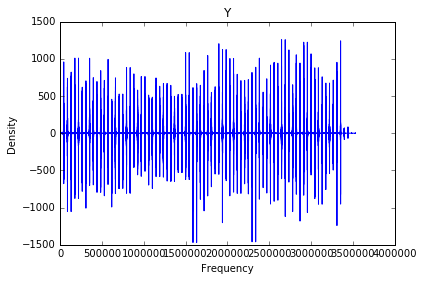

In [16]:
Y_flat = np.concatenate(Y)
plt.plot(Y_flat)
plt.title("Y")
plt.xlabel("Frequency")
plt.ylabel("Density")
plt.show()

In [17]:
cur_seq = 0
chunks_X = []
chunks_Y = []
max_seq_len = 10
total_seq = len(X)
while cur_seq + max_seq_len < total_seq:
    chunks_X.append(X[cur_seq:cur_seq + max_seq_len])
    chunks_Y.append(Y[cur_seq:cur_seq + max_seq_len])
    cur_seq += max_seq_len
# Number of examples
num_examples = len(chunks_X) 
# Imaginary part requires the extra space
num_dims_out = block_size * 2
# Dimensions of the training dataset
out_shape = (num_examples, max_seq_len, num_dims_out)
x_data = np.zeros(out_shape)
y_data = np.zeros(out_shape)
# Populating the training dataset
for n in range(num_examples):
    for i in range(max_seq_len):
        x_data[n][i] = chunks_X[n][i]
        y_data[n][i] = chunks_Y[n][i]

** Training dataset is ready! **
** Building the model. **

In [ ]:
num_frequency_dimensions = (np.shape(X))[1]
num_hidden_dimensions = 1024
print('Input layer size: ',num_frequency_dimensions)
print('Hidden layer size: ',num_hidden_dimensions)
# Sequential is a linear stack of layers
model = Sequential()
# This layer converts frequency space to hidden space
model.add(TimeDistributedDense(input_dim=num_frequency_dimensions, output_dim=num_hidden_dimensions))
# return_sequences=True implies return the entire output sequence & not just the last output
model.add(LSTM(input_dim=num_hidden_dimensions, output_dim=num_hidden_dimensions, return_sequences=True))
# This layer converts hidden space back to frequency space
model.add(TimeDistributedDense(input_dim=num_hidden_dimensions, output_dim=num_frequency_dimensions))
# Done building the model.Now, configure it for the learning process
model.compile(loss='mean_squared_error', optimizer='rmsprop')

Input layer size:  88200
Hidden layer size:  1024


/home/subbu/anaconda3/lib/python3.5/site-packages/keras/layers/core.py:1015: UserWarning: TimeDistributedDense is deprecated, please use TimeDistributed(Dense(...)) instead.
  warnings.warn('TimeDistributedDense is deprecated, '


In [ ]:
# Number of iterations for training
num_iters = 5
# Number of iterations before we save our model
epochs_per_iter = 3
# Number of training examples pushed to the GPU per batch.
batch_size = 5
# Path to weights file
weights_path = '/home/subbu/Desktop/Music Preprocessing/Weights'
cur_iter = 0
while cur_iter < num_iters:
    print('Iteration: ' + str(cur_iter))
    # Iterate over the training data in batches
    history = model.fit(x_data, y_data, batch_size=batch_size, nb_epoch=epochs_per_iter, verbose=1, validation_split=0.0)
    cur_iter += epochs_per_iter
print('Training complete!')
model.save_weights(weights_path)

Iteration: 0
Epoch 1/3
4/4 [==============================] - 2s - loss: 215.9425
Epoch 2/3
4/4 [==============================] - 2s - loss: 215.9183
Epoch 3/3
4/4 [==============================] - 2s - loss: 215.6781
Iteration: 3
Epoch 1/3
4/4 [==============================] - 1s - loss: 215.4013
Epoch 2/3
4/4 [==============================] - 1s - loss: 215.1780
Epoch 3/3
4/4 [==============================] - 1s - loss: 214.9787
Training complete!
[WARNING] /home/subbu/Desktop/Music Preprocessing/Weights already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!


** The training is complete and weights have been saved in the path specified! **

** Generating the song. We use a seed sequence which serves as a starter for the song. The model predicts the next note based on the previous sequence. **

In [ ]:
# We take the first chunk of the training data itself for seed sequence.
seed_seq = x_data[0]
# Reshaping the sequence to feed to the RNN.
seed_seq = np.reshape(seed_seq, (1, seed_seq.shape[0], seed_seq.shape[1]))
# Generated song sequence is stored in output.
output = []
for it in range(max_seq_len):
    # Generates new value
    seedSeqNew = model._predict(seed_seq) 
    # Appends it to the output
    if it == 0:
        for i in range(seedSeqNew.shape[1]):
            output.append(seedSeqNew[0][i].copy())
    else:
        output.append(seedSeqNew[0][seedSeqNew.shape[1]-1].copy()) 
    # newSeq contains the generated sequence.
    newSeq = seedSeqNew[0][seedSeqNew.shape[1]-1]
    # Reshaping the new sequence for concatenation.
    newSeq = np.reshape(newSeq, (1, 1, newSeq.shape[0]))
    # Appending the new sequence to the old sequence.
    seed_seq = np.concatenate((seed_seq, newSeq), axis=1)

In [ ]:
# The path for the generated song
song_path = '/home/subbu/Desktop/Music Preprocessing/gen_song.wav'
# Reversing the conversions
time_blocks = fft_blocks_to_time_blocks(output)
song = convert_sample_blocks_to_np_audio(time_blocks)
write_np_as_wav(song, sample_frequency, song_path)

** Let's listen to the song! **

In [ ]:
Audio(song_path)

** THE END. **